# Домашка 2

In [507]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [508]:
import matplotlib.pyplot as plt
%matplotlib inline

### Практика 7. Напишите функцию, которая подбирает оптимальные параметры для double_ema и ряда Monthly Boston armed robberies

In [509]:
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")

In [510]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    if not n_preds:
        return pd.Series(result)
    
    preds = []
    for _ in range(n_preds):
        value = result[-1]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
        preds.append(level + trend)
    
    #return series.append(pd.Series(preds), ignore_index=True), pd.Series(result)
    return pd.Series(result)

In [511]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [512]:
series = robberies_in_boston["Count"]
series.count()

118

In [513]:
train, test, val = series[:90], series[90:100], series[100:]
print(len(train), len(test), len(val))

90 10 18


In [514]:
def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [515]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [516]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 2144.525705205014
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.00295586, 0.04051799])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 21
   status: 0
  success: True
        x: array([0.14248924, 0.02471984])


In [517]:
def plot_dema(alpha, beta, ser, ser_to_plot, n_preds):
    dema = double_ema_with_preds(ser, alpha, beta, n_preds)
    #print(len(dema))
    #dema = dema[-n_preds:]
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(dema[:-n_preds], color='red', linewidth='1', label='DEMA')
        plt.plot(dema[-n_preds:], color='red', linewidth='2', label='pred')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

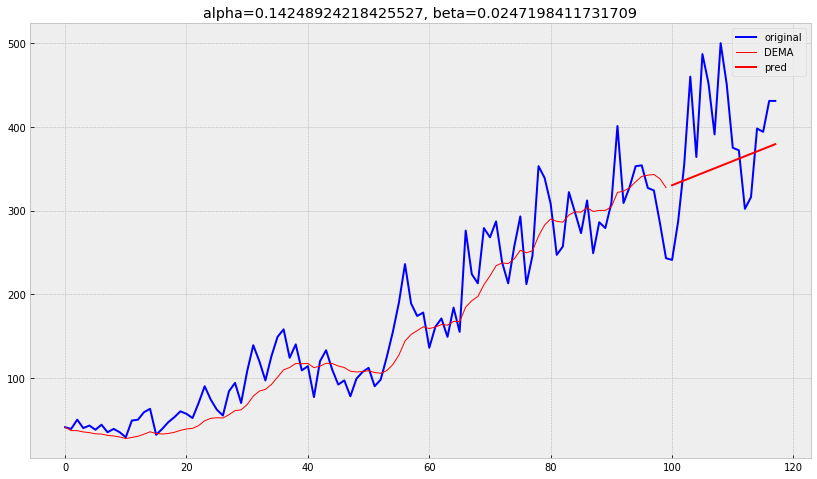

In [518]:
plot_dema(alpha_opt, beta_opt, ser=series[:-len(val)], ser_to_plot=series, n_preds=len(val))

## Домашнее задание

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

In [519]:
monthly_data = pd.read_csv("monthly-us-auto-registration-tho.csv", sep=';');
weekly_data = pd.read_csv("weekly-closings-of-the-dowjones.csv");

In [520]:
monthly_data.columns = ['Month', 'Sum']
weekly_data.columns = ['Week', 'Sum']

In [521]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

In [522]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [523]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [524]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [525]:
def plot_tema(alpha, beta, gamma, ser=monthly_data['Sum'], ser_to_plot=monthly_data['Sum'], n_preds=24):
    tema = triple_exponential_smoothing(ser, 65, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',linewidth='4', label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

### Набор данных 1

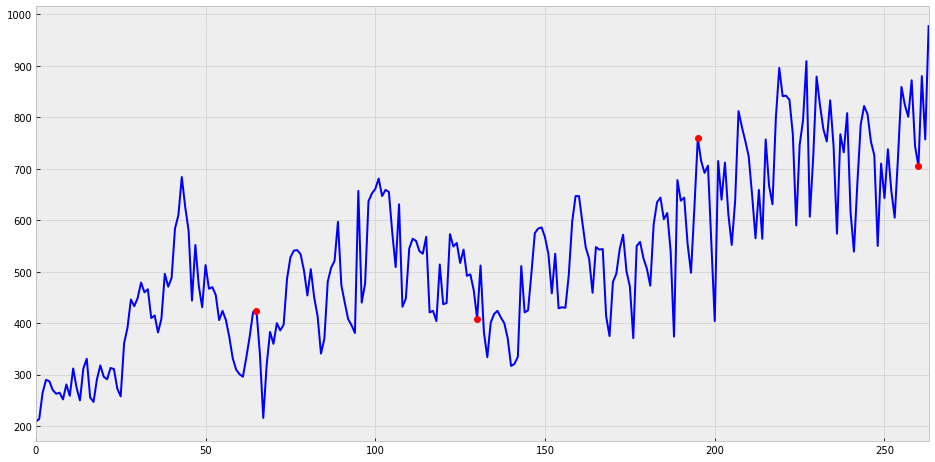

In [526]:
plot_ts_and_points(monthly_data['Sum'], 65, 65)

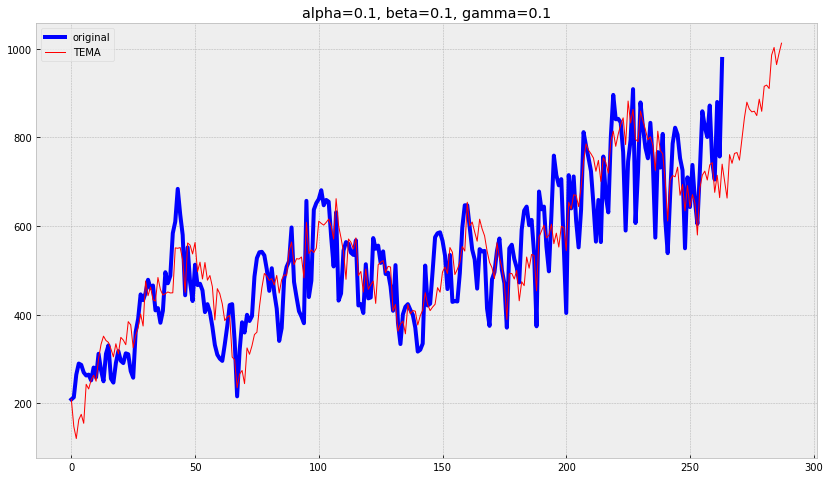

In [527]:
plot_tema(0.1, 0.1, 0.1)

In [528]:
series = monthly_data['Sum']
series.count()

264

In [529]:
tema_per = 12
test_size = 12

In [530]:
train, test, val = series[:(len(series)-test_size*2)], series[len(series)-test_size*2:len(series)-test_size], series[len(series)-test_size:]
print(len(train), len(test), len(val))

240 12 12


In [531]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, tema_per, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [532]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [533]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 8062.069020383231
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8100.63356766, 487625.83728603,      0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([1., 0., 1.])


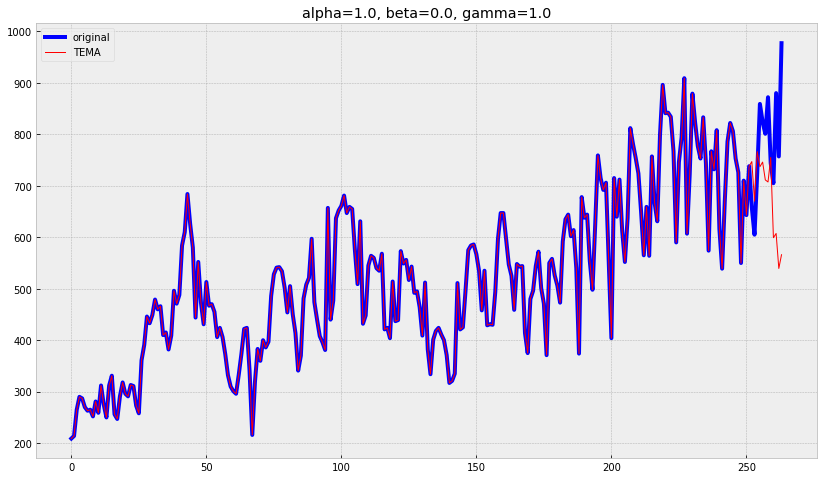

In [534]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=series[:len(train)+len(val)], ser_to_plot=series, n_preds=len(val))

In [535]:
predictions = triple_exponential_smoothing(series[:-len(val)], tema_per, alpha_opt, beta_opt, gamma_opt, len(val))
error = mean_squared_error(predictions, series)

In [536]:
print("RMSE: ", error)

RMSE:  507.28345257615024


In [537]:
#Использовал ТЕМА с периодом 12 и размером тестовой выборки 12. Предпологаю, что тут есть сезон.
#Описывает ряд хорошо, даже, наверное слишком хорошо, предсказывает не очень. Наверное тут все-таки нет сезона

### Набор данных 2

In [538]:
series = weekly_data['Sum']
series.count()

162

In [539]:
test_size = 10

In [540]:
train, test, val = series[:(len(series)-test_size*2)], series[len(series)-test_size*2:len(series)-test_size], series[len(series)-test_size:]
print(len(train), len(test), len(val))

142 10 10


In [541]:
def mse(X):
    alpha, beta = X
    result = double_ema_with_preds(train, alpha, beta, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [542]:
opt = minimize(mse, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [543]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 199.95180813986025
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00113687, -0.0005798 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 120
      nit: 25
   status: 0
  success: True
        x: array([0.23247498, 0.040908  ])


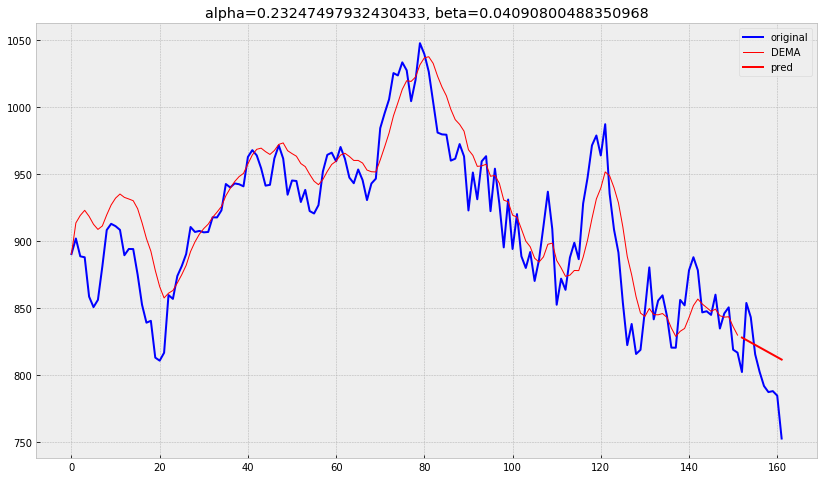

In [544]:
plot_dema(alpha_opt, beta_opt, ser=series[:len(train)+len(val)], ser_to_plot=series, n_preds=len(val))

In [545]:
    predictions = triple_exponential_smoothing(series[:-len(val)], tema_per, alpha_opt, beta_opt, gamma_opt, len(val))
    error = mean_squared_error(predictions, series)

In [546]:
print("RMSE: ", error)

RMSE:  116.74460559200514


In [410]:
# Использовал DEMA с размером тестовой выборки - 10, есть тренды и шум поэтому выбрал DEMA